In [2]:
!pip install transformers dataset 

  Using cached transformers-4.38.2-py3-none-any.whl (8.5 MB)
  Using cached dataset-1.6.2-py2.py3-none-any.whl (18 kB)
  Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (736 kB)
  Using cached tokenizers-0.15.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Using cached huggingface_hub-0.21.4-py3-none-any.whl (346 kB)
  Using cached regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (777 kB)
  Using cached safetensors-0.4.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached banal-1.0.6-py2.py3-none-any.whl (6.1 kB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
ERROR: Could not install packages due to an E

In [3]:
!pip install -U sentence-transformers

  Using cached sentence_transformers-2.5.1-py3-none-any.whl (156 kB)
  Using cached huggingface_hub-0.21.4-py3-none-any.whl (346 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached transformers-4.38.2-py3-none-any.whl (8.5 MB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached torch-2.2.1-cp38-cp38-manylinux1_x86_64.whl (755.5 MB)
  Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Using cached pillow-10.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
  Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (736 kB)
  Using cached joblib-1.3.

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("emotion")["train"]

In [3]:
df = dataset.to_pandas()
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [4]:
df['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [5]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [6]:
mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',  #rabbia
    4: 'fear',
    5: 'surprise'
}

In [7]:
dataset_val = load_dataset("emotion")["validation"]
df_val = dataset_val.to_pandas()

In [8]:
from sentence_transformers import SentenceTransformer, models
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define a model that will embed individual words
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256).to(device)
 
# Define a model that will pool each individual words
# NOTE: This automatically uses average pooling but other strategies exist
# such as taking the maximum or mode of word embeddings across all dimensions
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
 
# Create
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

cuda


In [9]:
from sentence_transformers import losses
 
# Define the loss function. In soft-max loss, we will also need to explicitly set the number of labels.
#train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
train_loss = losses.BatchAllTripletLoss(model=model)

In [10]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import InputExample
 
train_examples = [InputExample(texts=[row["text"]],  
                               label=row["label"]) for row in tqdm(dataset)]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [ ]:
# Train our model for a single epoch
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=100, show_progress_bar=True)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
 
# # Create an embedding similarity evaluator for stsb
# evaluator = EmbeddingSimilarityEvaluator.from_input_examples(samples)

In [ ]:
sentences1 = [row["text"] for row in tqdm(dataset_val)]

In [ ]:
embeddings1 = model.encode(sentences1, convert_to_tensor=True)

In [ ]:
import numpy as np

In [ ]:
emb1 = embeddings1.cpu().numpy()
matrix_emb = emb1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(matrix_emb)

In [ ]:
labels = [row["label"] for row in tqdm(dataset_val)]

In [ ]:
df = pd.DataFrame(data = tsne_results, columns = ['x', 'y'])
df['label'] = labels 

In [ ]:
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'label' )

In [ ]:
df['text'] = sentences1
df['human_label'] = df['label'].apply(lambda l: mapping[l])
df['id'] = [i for i in range(df.shape[0])]

In [ ]:
df

In [ ]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", color="human_label", symbol = 'human_label',
                  hover_data=['text', 'id'], width=1200, height=600,
                title = "BERT con triple-loss, visualizzazione feature space dei suoi embedding con T-SNE",
                  labels={
                     "x": "dim 1",
                     "y": "dim 2",
                     "human_label": "ground truth"
                 }
                )

fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
df[df['id']==415]['text'].values # frase di goia eticchetata dalla persona come rabbia, un classificatore lo classificherebbe come joy corretamente

In [37]:
df[df['id']==292]['text'].values # ci sta che di ettichettarla o come love joy

array(['i can say is that i feel like myself when i put on a skirt heels and lipstick and when i wear clothing which has come to be accepted as neutral and nondescript like a t shirt and jeans i dont feel like myself'],
      dtype=object)

In [38]:
df[df['id']==1658]['text'].values # anche questa  il messaggio è di ottimismo alla fine, quindi non la metterei tanto sulla rabbia 

array(['i said before i feel like a hypocrite advocating for diabetes support and awareness without supporting my own situation'],
      dtype=object)

In [39]:
df[df['id']==1112]['text'].values # sembra sarcasmo

array(['i feel gracious what about you'], dtype=object)

In [40]:
df[df['id']==1304]['text'].values # sembra sarcasmo

array(['i feel not just attracted to but completely enthralled and captivated by him like hes some kind of other worldly creature with nothing inside him but a really bright light'],
      dtype=object)

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
neigh = KNeighborsClassifier(n_neighbors=10)

In [31]:
neigh.fit(df[['x','y']].values, y=df[['label']].values)

/newhome/utented18/.local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KNeighborsClassifier(n_neighbors=10)

In [32]:
pred = neigh.predict(df[['x','y']].values)

In [33]:
df['knn_prediction'] = pred
df['knn_prediction_human_readable'] = df['knn_prediction'].apply(lambda l: mapping[l])
df

,x,y,label,text,human_label,id,knn_prediction,knn_prediction_human_readable
0,39.145927,-20.721405,0,im feeling quite sad and sorry for myself but ...,sadness,0,0,sadness
1,32.426247,-18.013155,0,i feel like i am still looking at a blank canv...,sadness,1,0,sadness
2,-37.286926,9.289138,2,i feel like a faithful servant,love,2,1,joy
3,44.780045,24.028728,3,i am just feeling cranky and blue,anger,3,3,anger
4,-39.526478,-18.751057,1,i can have for a treat or if i am feeling festive,joy,4,1,joy
...,...,...,...,...,...,...,...,...
1995,17.766521,-26.506191,0,im having ssa examination tomorrow in the morn...,sadness,1995,0,sadness
1996,-37.437775,-6.244614,1,i constantly worry about their fight against n...,joy,1996,1,joy
1997,-29.917948,-2.962977,1,i feel its important to share this info for th...,joy,1997,1,joy
1998,-34.177082,12.042692,1,i truly feel that if you are passionate enough...,joy,1998,1,joy


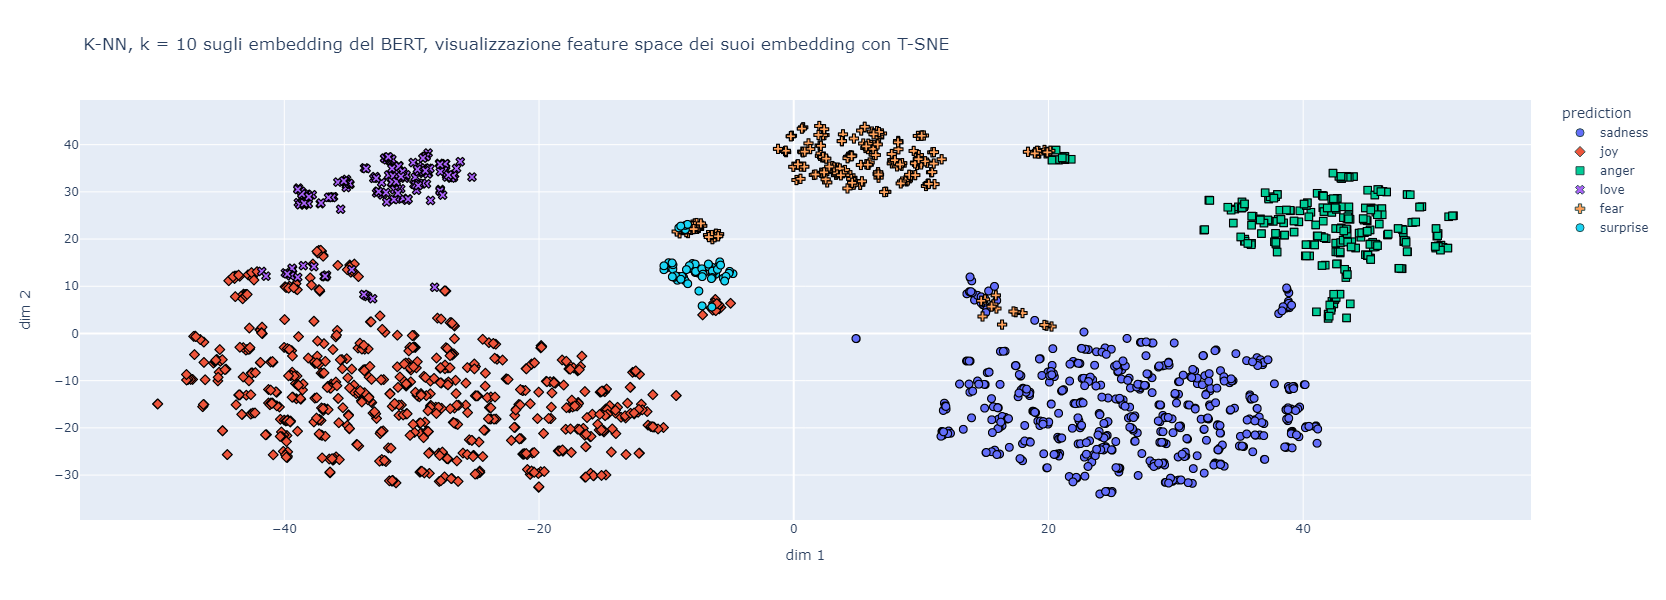

In [34]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", color="knn_prediction_human_readable", symbol = 'knn_prediction_human_readable',
                  hover_data=['text', 'id'], width=1200, height=600,
                title = "K-NN, k = 10 sugli embedding del BERT, visualizzazione feature space dei suoi embedding con T-SNE",
                  labels={
                     "x": "dim 1",
                     "y": "dim 2",
                     "knn_prediction_human_readable": "prediction"
                 }
                )

fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()